C:\Users\ABTTr\AppData\Local\Temp\ipykernel_43156\395991572.py:99: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlGn')  # reversed: red = low, green = high
C:\Users\ABTTr\AppData\Local\Temp\ipykernel_43156\395991572.py:99: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlGn')  # reversed: red = low, green = high
C:\Users\ABTTr\AppData\Local\Temp\ipykernel_43156\395991572.py:196: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


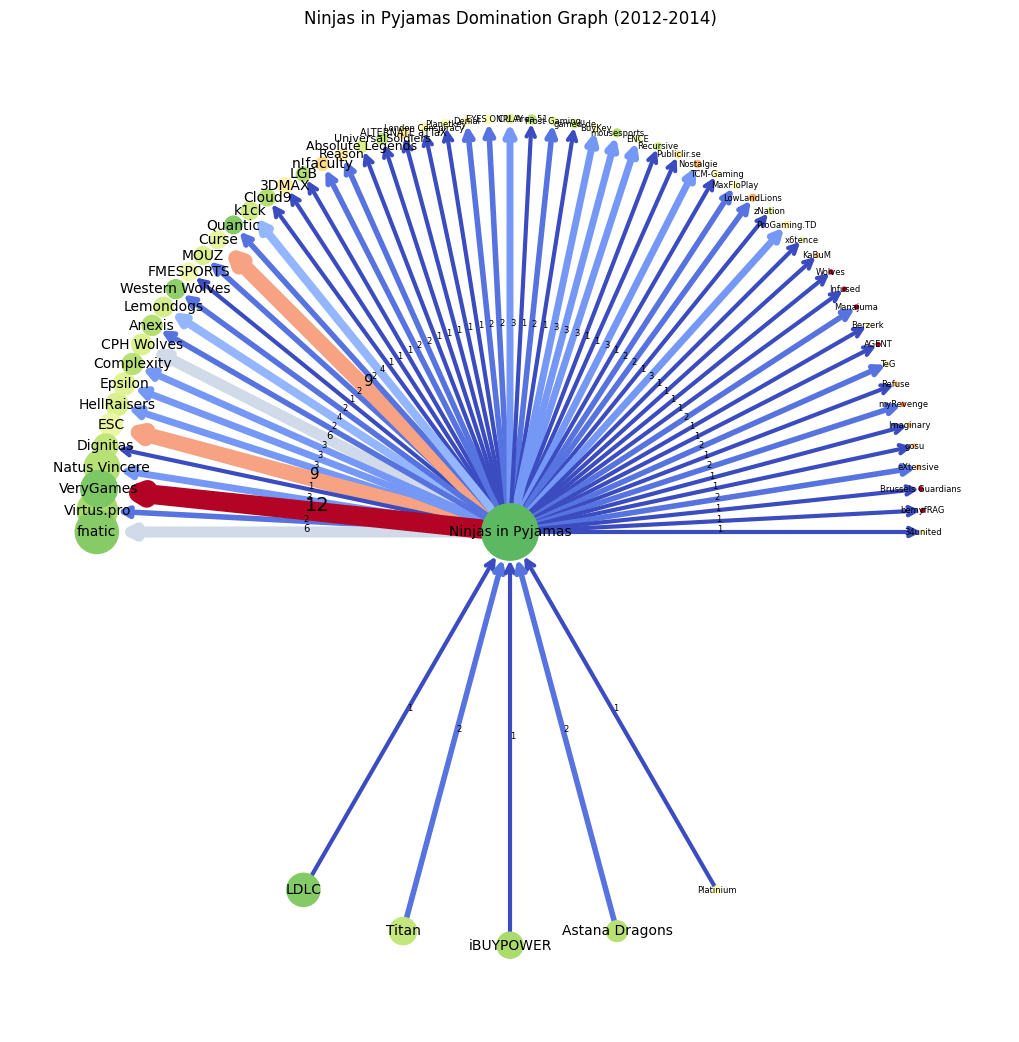

In [84]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import re
from collections import defaultdict
from datetime import datetime
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import PowerNorm
# Load the data
df = pd.read_csv("data/every_map.csv")

# Helper: extract clean team name (no parentheses)
def clean_name(name_with_score):
    return re.sub(r'\s*\(.*?\)', '', name_with_score)#.lower().strip()

# Clean names
df["Team1_Clean"] = df["Team1_Text"].apply(clean_name)
df["Team2_Clean"] = df["Team2_Text"].apply(clean_name)

# Convert date to datetime
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
astralis = "Ninjas in Pyjamas"
# Function to build domination graph for Astralis for a given time range
def build_domination_graph(df, start_year, end_year):
    global astralis
    # Filter for the date range
    df_range = df[(df["Date"].dt.year >= start_year) & (df["Date"].dt.year <= end_year)]
    
    # Create a dictionary to store total wins for each team (including Astralis)
    total_wins = defaultdict(int)
    total_losses = defaultdict(int)
    # Count wins for all teams in the time period
    for _, row in df_range.iterrows():
        t1, t2 = row["Team1_Clean"], row["Team2_Clean"]
        s1, s2 = row["Team1_Score"], row["Team2_Score"]
        
        if s1 > s2:
            total_wins[t1] += 1
            total_losses[t2] += 1
        elif s2 > s1:
            total_wins[t2] += 1
            total_losses[t1] += 1
    
    # Only games involving Astralis
    df_astralis = df_range[
        (df_range["Team1_Clean"] == astralis) | (df_range["Team2_Clean"] == astralis)
    ]

    matchups = defaultdict(lambda: {"maps": [0, 0], "rounds": [0, 0]})  # team -> [maps_won, rounds_won]

    for _, row in df_astralis.iterrows():
        t1, t2 = row["Team1_Clean"], row["Team2_Clean"]
        s1, s2 = row["Team1_Score"], row["Team2_Score"]

        # Identify opponent and who won
        if t1 == astralis:
            opponent = t2
            if s1 > s2:
                matchups[opponent]["maps"][0] += 1  # Astralis win
            elif s1 < s2:
                matchups[opponent]["maps"][1] += 1
            matchups[opponent]["rounds"][0] += s1
            matchups[opponent]["rounds"][1] += s2
        elif t2 == astralis:
            opponent = t1
            if s2 > s1:
                matchups[opponent]["maps"][0] += 1  # Astralis win
            elif s2 < s1:
                matchups[opponent]["maps"][1] += 1
            matchups[opponent]["rounds"][0] += s2
            matchups[opponent]["rounds"][1] += s1

    # Build graph
    G = nx.DiGraph()

    for opponent, stats in matchups.items():
        astralis_maps, opp_maps = stats["maps"]
        astralis_rounds, opp_rounds = stats["rounds"]

        # Add nodes with size attribute based on total wins
        G.add_node(astralis, size=total_wins.get(astralis, 1))
        G.add_node(opponent, size=total_wins.get(opponent, 1))

        if astralis_maps > opp_maps:
            G.add_edge(astralis, opponent, weight=astralis_maps - opp_maps)
        elif opp_maps > astralis_maps:
            G.add_edge(opponent, astralis, weight=opp_maps - astralis_maps)
        else:
            G.add_edge(astralis, opponent, weight=0.5)
            G.add_edge(opponent, astralis, weight=0.5)
            # tie in maps, go by rounds
            # if astralis_rounds > opp_rounds:
            #     G.add_edge("FURIA", opponent, weight=0.5)
            # elif opp_rounds > astralis_rounds:
            #     G.add_edge(opponent, "Astralis", weight=0.5)
            # If even rounds too, no edge
            
    cmap = cm.get_cmap('RdYlGn')  # reversed: red = low, green = high
    norm = PowerNorm(gamma=0.7, vmin=0, vmax=1)        
    node_colors = [cmap(norm(total_wins.get(node,0)/(total_losses[node]+total_wins[node]))) for node in G.nodes()]
    return G, node_colors

# Build both graphs


def custom_astralis_layout(G):
    center = astralis
    pos = {center: np.array([0.0, 0.0])}

    dominated = []
    dominated_by = []
    tied = []

    for node in G.nodes():
        if node == center:
            continue
        
        astralis_edge = G.get_edge_data(center, node)
        reverse_edge = G.get_edge_data(node, center)
        
        if astralis_edge and not reverse_edge:
            dominated.append(node)
        elif reverse_edge and not astralis_edge:
            dominated_by.append(node)
        elif astralis_edge and reverse_edge:
            tied.append(node)

    # Sort by node size (larger to smaller)
    dominated.sort(key=lambda n: G.nodes[n]['size'], reverse=True)
    dominated_by.sort(key=lambda n: G.nodes[n]['size'], reverse=True)
    tied.sort(key=lambda n: G.nodes[n]['size'], reverse=True)

    radius = 3

    def place_nodes(nodes, start_angle, end_angle):
        n = len(nodes)
        if n == 0:
            return
        angles = np.linspace(start_angle, end_angle, n)
        label_offsets = {}

        for angle, node in zip(angles, nodes):
            x = radius * np.cos(angle)
            y = radius * np.sin(angle)
            pos[node] = np.array([x, y])

    # Place dominated teams on the RIGHT (−π/2 to π/2)
    place_nodes(dominated, np.pi, 0)

    # Place dominating teams on the LEFT (2π/3 to 4π/3)
    place_nodes(dominated_by, 4*np.pi/3, 5*np.pi/3)

    # Place tied teams on the BOTTOM (5π/4 to 7π/4)
    # place_nodes(tied, 5*np.pi/4, 7*np.pi/4)

    return pos

def draw_graph(G, nodecolors, title):
    pos = custom_astralis_layout(G)
    weights = [G[u][v]["weight"] for u, v in G.edges()]
    node_sizes = [G.nodes[node]['size'] * 8 for node in G.nodes()]
    
    # Normalize font sizes for nodes
    font_sizes = {node: min(10, max(6, G.nodes[node]['size'] * 1)) for node in G.nodes()}
    
    # Normalize font sizes for edges
    edge_font_sizes = { (u, v): min(14, max(6, G[u][v]['weight'] * 1.2)) for u, v in G.edges() }

    plt.figure(figsize=(10, 10))

    # Draw nodes and edges
    nx.draw(G, pos, node_color=nodecolors, edge_color=weights,
            edge_cmap=plt.cm.coolwarm, width=[2 + w for w in weights],
            node_size=node_sizes, arrows=True, arrowstyle='->', arrowsize=15)

    # Draw node labels with individual font sizes
    for node, (x, y) in pos.items():
        # Calculate angle from center
        angle = np.arctan2(y, x)
        dx = 0.15 * np.cos(angle)
        dy = 0.15 * np.sin(angle)
        dx,dy = 0,0
        plt.text(x + dx, y + dy, s=str(node), fontsize=font_sizes[node], ha='center', va='center')

    # Draw edge labels with individual font sizes
    edge_labels = {(u, v): G[u][v]['weight'] for u, v in G.edges()}
    for (u, v), label in edge_labels.items():
        (x1, y1) = pos[u]
        (x2, y2) = pos[v]
        x, y = (x1 + x2) / 2, (y1 + y2) / 2
        plt.text(x, y, s=str(label), fontsize=edge_font_sizes[(u, v)], color='black')

    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Draw both
start_old, end_old = 2012, 2014
start_new, end_new = 2023, 2025
graph_2018_2019, nc_old = build_domination_graph(df, start_old, end_old)
graph_2023_2025, nc_new = build_domination_graph(df, start_new, end_new)
draw_graph(graph_2018_2019, nc_old, f"{astralis} Domination Graph ({start_old}-{end_old})")
# draw_graph(graph_2023_2025, nc_new, f"{astralis} Domination Graph ({start_new}-{end_new})")



C:\Users\ABTTr\AppData\Local\Temp\ipykernel_43156\3352344552.py:99: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlGn')  # reversed: red = low, green = high
C:\Users\ABTTr\AppData\Local\Temp\ipykernel_43156\3352344552.py:203: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


{'Ninjas in Pyjamas': array([0., 0.]), 'Spirit': array([2.59807621, 1.5       ]), 'FURIA': array([2.38006002, 1.82628429]), 'Complexity': array([2.12132034, 2.12132034]), 'BIG': array([1.82628429, 2.38006002]), 'ENCE': array([1.5       , 2.59807621]), 'Cloud9': array([1.1480503, 2.7716386]), 'paiN': array([0.77645714, 2.89777748]), 'MIBR': array([0.39157858, 2.97433458]), 'OG': array([1.8369702e-16, 3.0000000e+00]), 'Imperial': array([-0.39157858,  2.97433458]), '9INE': array([-0.77645714,  2.89777748]), 'Grayhound': array([-1.1480503,  2.7716386]), 'Evil Geniuses': array([-1.5       ,  2.59807621]), 'Into the Breach': array([-1.82628429,  2.38006002]), 'Sashi': array([-2.12132034,  2.12132034]), 'BOSS': array([-2.38006002,  1.82628429]), 'Wings Up': array([-2.59807621,  1.5       ]), 'FaZe': array([-2.59807621, -1.5       ]), 'G2': array([-2.36403226, -1.84698443]), 'Vitality': array([-2.08397511, -2.1580194 ]), 'Natus Vincere': array([-1.76335576, -2.42705098]), 'MOUZ': array([-1.408

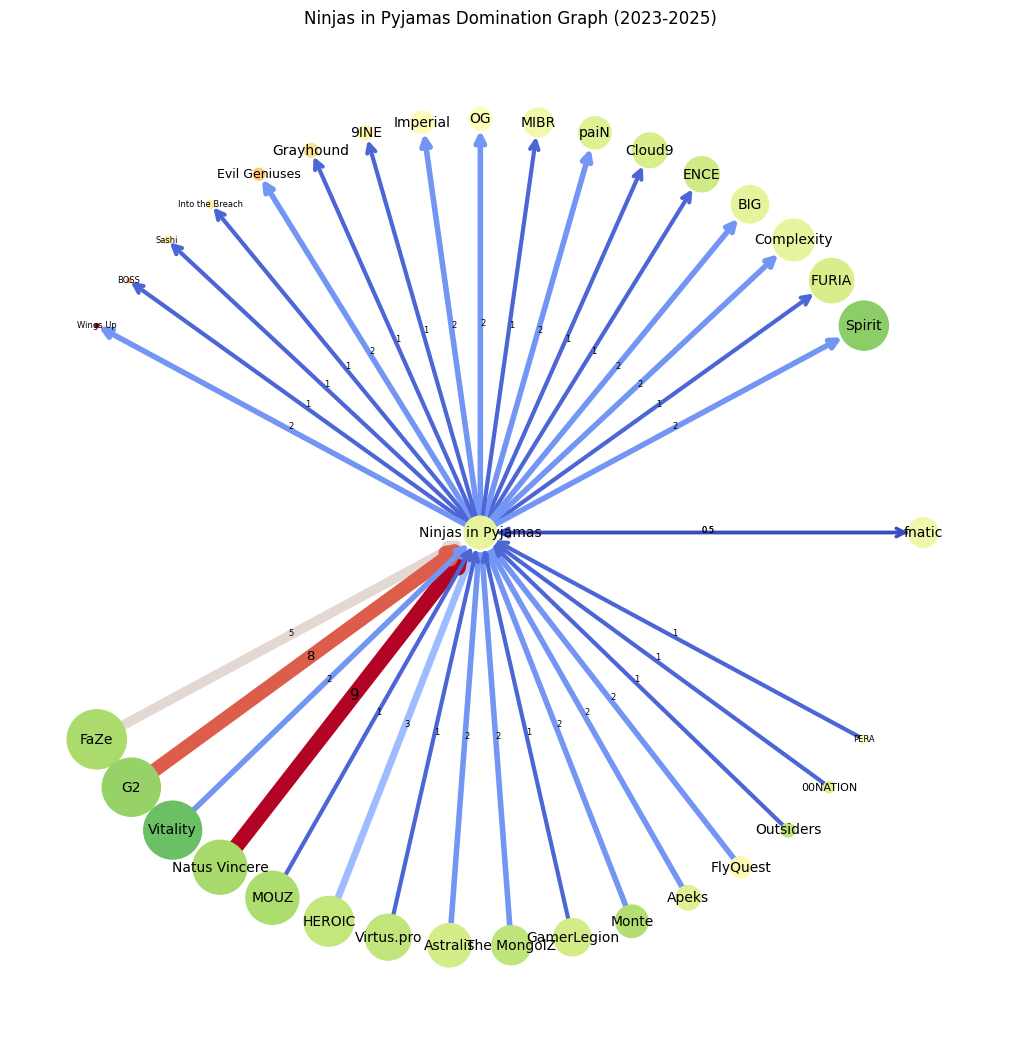

In [82]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import re
from collections import defaultdict
from datetime import datetime
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import PowerNorm
# Load the data
df = pd.read_csv("data/every_map.csv")

# Helper: extract clean team name (no parentheses)
def clean_name(name_with_score):
    return re.sub(r'\s*\(.*?\)', '', name_with_score)#.lower().strip()

# Clean names
df["Team1_Clean"] = df["Team1_Text"].apply(clean_name)
df["Team2_Clean"] = df["Team2_Text"].apply(clean_name)

# Convert date to datetime
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
astralis = "Ninjas in Pyjamas"
# Function to build domination graph for Astralis for a given time range
def build_domination_graph(df, start_year, end_year):
    global astralis
    # Filter for the date range
    df_range = df[(df["Date"].dt.year >= start_year) & (df["Date"].dt.year <= end_year)]
    
    # Create a dictionary to store total wins for each team (including Astralis)
    total_wins = defaultdict(int)
    total_losses = defaultdict(int)
    # Count wins for all teams in the time period
    for _, row in df_range.iterrows():
        t1, t2 = row["Team1_Clean"], row["Team2_Clean"]
        s1, s2 = row["Team1_Score"], row["Team2_Score"]
        
        if s1 > s2:
            total_wins[t1] += 1
            total_losses[t2] += 1
        elif s2 > s1:
            total_wins[t2] += 1
            total_losses[t1] += 1
    
    # Only games involving Astralis
    df_astralis = df_range[
        (df_range["Team1_Clean"] == astralis) | (df_range["Team2_Clean"] == astralis)
    ]

    matchups = defaultdict(lambda: {"maps": [0, 0], "rounds": [0, 0]})  # team -> [maps_won, rounds_won]

    for _, row in df_astralis.iterrows():
        t1, t2 = row["Team1_Clean"], row["Team2_Clean"]
        s1, s2 = row["Team1_Score"], row["Team2_Score"]

        # Identify opponent and who won
        if t1 == astralis:
            opponent = t2
            if s1 > s2:
                matchups[opponent]["maps"][0] += 1  # Astralis win
            elif s1 < s2:
                matchups[opponent]["maps"][1] += 1
            matchups[opponent]["rounds"][0] += s1
            matchups[opponent]["rounds"][1] += s2
        elif t2 == astralis:
            opponent = t1
            if s2 > s1:
                matchups[opponent]["maps"][0] += 1  # Astralis win
            elif s2 < s1:
                matchups[opponent]["maps"][1] += 1
            matchups[opponent]["rounds"][0] += s2
            matchups[opponent]["rounds"][1] += s1

    # Build graph
    G = nx.DiGraph()

    for opponent, stats in matchups.items():
        astralis_maps, opp_maps = stats["maps"]
        astralis_rounds, opp_rounds = stats["rounds"]

        # Add nodes with size attribute based on total wins
        G.add_node(astralis, size=total_wins.get(astralis, 1))
        G.add_node(opponent, size=total_wins.get(opponent, 1))

        if astralis_maps > opp_maps:
            G.add_edge(astralis, opponent, weight=astralis_maps - opp_maps)
        elif opp_maps > astralis_maps:
            G.add_edge(opponent, astralis, weight=opp_maps - astralis_maps)
        else:
            G.add_edge(astralis, opponent, weight=0.5)
            G.add_edge(opponent, astralis, weight=0.5)
            # tie in maps, go by rounds
            # if astralis_rounds > opp_rounds:
            #     G.add_edge("FURIA", opponent, weight=0.5)
            # elif opp_rounds > astralis_rounds:
            #     G.add_edge(opponent, "Astralis", weight=0.5)
            # If even rounds too, no edge
            
    cmap = cm.get_cmap('RdYlGn')  # reversed: red = low, green = high
    norm = PowerNorm(gamma=0.7, vmin=0, vmax=1)        
    node_colors = [cmap(norm(total_wins.get(node,0)/(total_losses[node]+total_wins[node]))) for node in G.nodes()]
    return G, node_colors

# Build both graphs


def custom_astralis_layout(G):
    center = astralis
    pos = {center: np.array([0.0, 0.0])}

    dominated = []
    dominated_by = []
    tied = []

    for node in G.nodes():
        if node == center:
            continue
        
        astralis_edge = G.get_edge_data(center, node)
        reverse_edge = G.get_edge_data(node, center)
        
        if astralis_edge and not reverse_edge:
            dominated.append(node)
        elif reverse_edge and not astralis_edge:
            dominated_by.append(node)
        elif astralis_edge and reverse_edge:
            tied.append(node)

    # Sort by node size (larger to smaller)
    dominated.sort(key=lambda n: G.nodes[n]['size'], reverse=True)
    dominated_by.sort(key=lambda n: G.nodes[n]['size'], reverse=True)
    tied.sort(key=lambda n: G.nodes[n]['size'], reverse=True)

    radius = 3

    def place_nodes(nodes, start_angle, end_angle):
        n = len(nodes)
        if n == 0:
            return
        angles = np.linspace(start_angle, end_angle, n)
        label_offsets = {}

        for angle, node in zip(angles, nodes):
            x = radius * np.cos(angle)
            y = radius * np.sin(angle)
            pos[node] = np.array([x, y])

    # Place dominated teams on the RIGHT (−π/2 to π/2)
    place_nodes(dominated, np.pi/6, 5*np.pi/6)

    # Place dominating teams on the LEFT (2π/3 to 4π/3)
    place_nodes(dominated_by, np.pi+(np.pi/6), np.pi+(5*np.pi/6))

    # Place tied teams on the BOTTOM (5π/4 to 7π/4)
    place_nodes(tied, 0,0)

    return pos

def draw_graph(G, nodecolors, title):
    pos = custom_astralis_layout(G)
    weights = [G[u][v]["weight"] for u, v in G.edges()]
    node_sizes = [G.nodes[node]['size'] * 8 for node in G.nodes()]
    
    # Normalize font sizes for nodes
    font_sizes = {node: min(10, max(6, G.nodes[node]['size'] * 1)) for node in G.nodes()}
    
    # Normalize font sizes for edges
    edge_font_sizes = { (u, v): min(14, max(6, G[u][v]['weight'] * 1.2)) for u, v in G.edges() }

    plt.figure(figsize=(10, 10))

    # Draw nodes and edges
    nx.draw(G, pos, node_color=nodecolors, edge_color=weights,
            edge_cmap=plt.cm.coolwarm, width=[2 + w for w in weights],
            node_size=node_sizes, arrows=True, arrowstyle='->', arrowsize=15)

    # Draw node labels with individual font sizes
    print(pos)
    for node, (x, y) in pos.items():
        # if y>-2.99:
        # Calculate angle from center
            angle = np.arctan2(y, x)
            dx = 0.15 * np.cos(angle)
            dy = 0.15 * np.sin(angle)
            dx, dy = 0,0
            plt.text(x + dx, y + dy, s=str(node), fontsize=font_sizes[node], ha='center', va='center')
        # else:
        #     if str(node)=="Astralis":
        #         plt.text(x + dx, -3.2, s=str(node), fontsize=font_sizes[node], ha='center', va='center')
        #     else:
        #         plt.text(x + dx, -2.9, s=str(node), fontsize=font_sizes[node], ha='center', va='center')

    # Draw edge labels with individual font sizes
    edge_labels = {(u, v): G[u][v]['weight'] for u, v in G.edges()}
    for (u, v), label in edge_labels.items():
        (x1, y1) = pos[u]
        (x2, y2) = pos[v]
        x, y = (x1 + x2) / 2, (y1 + y2) / 2
        plt.text(x, y, s=str(label), fontsize=edge_font_sizes[(u, v)], color='black')

    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Draw both
start_old, end_old = 2012, 2014
start_new, end_new = 2023, 2025
# graph_2018_2019, nc_old = build_domination_graph(df, start_old, end_old)
graph_2023_2025, nc_new = build_domination_graph(df, start_new, end_new)
# draw_graph(graph_2018_2019, nc_old, f"{astralis} Domination Graph ({start_old}-{end_old})")
draw_graph(graph_2023_2025, nc_new, f"{astralis} Domination Graph ({start_new}-{end_new})")

C:\Users\ABTTr\AppData\Local\Temp\ipykernel_43156\1788857525.py:99: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlGn')  # reversed: red = low, green = high
C:\Users\ABTTr\AppData\Local\Temp\ipykernel_43156\1788857525.py:196: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


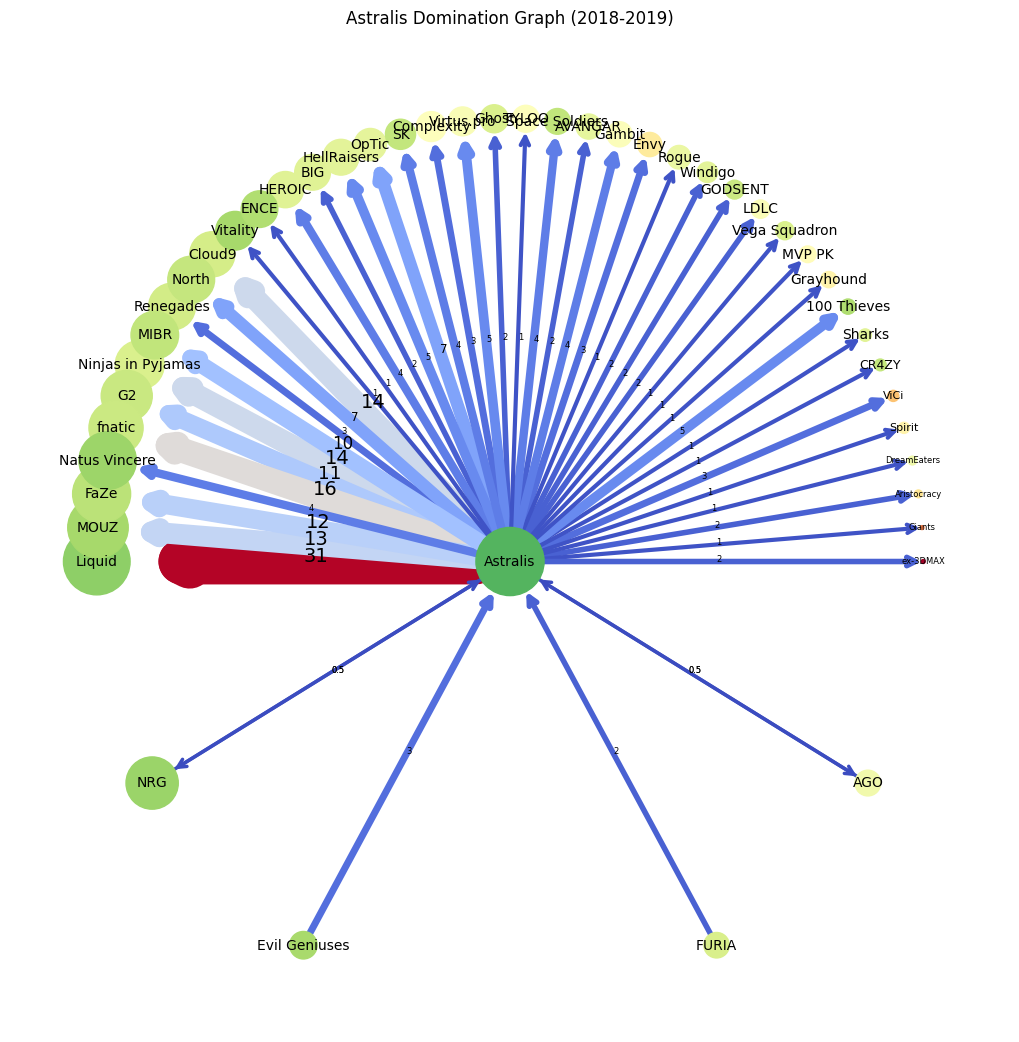

In [93]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import re
from collections import defaultdict
from datetime import datetime
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import PowerNorm
# Load the data
df = pd.read_csv("data/every_map.csv")

# Helper: extract clean team name (no parentheses)
def clean_name(name_with_score):
    return re.sub(r'\s*\(.*?\)', '', name_with_score)#.lower().strip()

# Clean names
df["Team1_Clean"] = df["Team1_Text"].apply(clean_name)
df["Team2_Clean"] = df["Team2_Text"].apply(clean_name)

# Convert date to datetime
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
astralis = "Astralis"
# Function to build domination graph for Astralis for a given time range
def build_domination_graph(df, start_year, end_year):
    global astralis
    # Filter for the date range
    df_range = df[(df["Date"].dt.year >= start_year) & (df["Date"].dt.year <= end_year)]
    
    # Create a dictionary to store total wins for each team (including Astralis)
    total_wins = defaultdict(int)
    total_losses = defaultdict(int)
    # Count wins for all teams in the time period
    for _, row in df_range.iterrows():
        t1, t2 = row["Team1_Clean"], row["Team2_Clean"]
        s1, s2 = row["Team1_Score"], row["Team2_Score"]
        
        if s1 > s2:
            total_wins[t1] += 1
            total_losses[t2] += 1
        elif s2 > s1:
            total_wins[t2] += 1
            total_losses[t1] += 1
    
    # Only games involving Astralis
    df_astralis = df_range[
        (df_range["Team1_Clean"] == astralis) | (df_range["Team2_Clean"] == astralis)
    ]

    matchups = defaultdict(lambda: {"maps": [0, 0], "rounds": [0, 0]})  # team -> [maps_won, rounds_won]

    for _, row in df_astralis.iterrows():
        t1, t2 = row["Team1_Clean"], row["Team2_Clean"]
        s1, s2 = row["Team1_Score"], row["Team2_Score"]

        # Identify opponent and who won
        if t1 == astralis:
            opponent = t2
            if s1 > s2:
                matchups[opponent]["maps"][0] += 1  # Astralis win
            elif s1 < s2:
                matchups[opponent]["maps"][1] += 1
            matchups[opponent]["rounds"][0] += s1
            matchups[opponent]["rounds"][1] += s2
        elif t2 == astralis:
            opponent = t1
            if s2 > s1:
                matchups[opponent]["maps"][0] += 1  # Astralis win
            elif s2 < s1:
                matchups[opponent]["maps"][1] += 1
            matchups[opponent]["rounds"][0] += s2
            matchups[opponent]["rounds"][1] += s1

    # Build graph
    G = nx.DiGraph()

    for opponent, stats in matchups.items():
        astralis_maps, opp_maps = stats["maps"]
        astralis_rounds, opp_rounds = stats["rounds"]

        # Add nodes with size attribute based on total wins
        G.add_node(astralis, size=total_wins.get(astralis, 1))
        G.add_node(opponent, size=total_wins.get(opponent, 1))

        if astralis_maps > opp_maps:
            G.add_edge(astralis, opponent, weight=astralis_maps - opp_maps)
        elif opp_maps > astralis_maps:
            G.add_edge(opponent, astralis, weight=opp_maps - astralis_maps)
        else:
            G.add_edge(astralis, opponent, weight=0.5)
            G.add_edge(opponent, astralis, weight=0.5)
            # tie in maps, go by rounds
            # if astralis_rounds > opp_rounds:
            #     G.add_edge("FURIA", opponent, weight=0.5)
            # elif opp_rounds > astralis_rounds:
            #     G.add_edge(opponent, "Astralis", weight=0.5)
            # If even rounds too, no edge
            
    cmap = cm.get_cmap('RdYlGn')  # reversed: red = low, green = high
    norm = PowerNorm(gamma=0.7, vmin=0, vmax=1)        
    node_colors = [cmap(norm(total_wins.get(node,0)/(total_losses[node]+total_wins[node]))) for node in G.nodes()]
    return G, node_colors

# Build both graphs


def custom_astralis_layout(G):
    center = astralis
    pos = {center: np.array([0.0, 0.0])}

    dominated = []
    dominated_by = []
    tied = []

    for node in G.nodes():
        if node == center:
            continue
        
        astralis_edge = G.get_edge_data(center, node)
        reverse_edge = G.get_edge_data(node, center)
        
        if astralis_edge and not reverse_edge:
            dominated.append(node)
        elif reverse_edge and not astralis_edge:
            dominated_by.append(node)
        elif astralis_edge and reverse_edge:
            tied.append(node)

    # Sort by node size (larger to smaller)
    dominated.sort(key=lambda n: G.nodes[n]['size'], reverse=True)
    dominated_by.sort(key=lambda n: G.nodes[n]['size'], reverse=True)
    tied.sort(key=lambda n: G.nodes[n]['size'], reverse=True)

    radius = 3

    def place_nodes(nodes, start_angle, end_angle):
        n = len(nodes)
        if n == 0:
            return
        angles = np.linspace(start_angle, end_angle, n)
        label_offsets = {}

        for angle, node in zip(angles, nodes):
            x = radius * np.cos(angle)
            y = radius * np.sin(angle)
            pos[node] = np.array([x, y])

    # Place dominated teams on the RIGHT (−π/2 to π/2)
    place_nodes(dominated, np.pi, 0)

    # Place dominating teams on the LEFT (2π/3 to 4π/3)
    place_nodes(dominated_by, 4*np.pi/3, 5*np.pi/3)

    # Place tied teams on the BOTTOM (5π/4 to 7π/4)
    place_nodes(tied, 7*np.pi/6, 11*np.pi/6)

    return pos

def draw_graph(G, nodecolors, title):
    pos = custom_astralis_layout(G)
    weights = [G[u][v]["weight"] for u, v in G.edges()]
    node_sizes = [G.nodes[node]['size'] * 8 for node in G.nodes()]
    
    # Normalize font sizes for nodes
    font_sizes = {node: min(10, max(6, G.nodes[node]['size'] * 1)) for node in G.nodes()}
    
    # Normalize font sizes for edges
    edge_font_sizes = { (u, v): min(14, max(6, G[u][v]['weight'] * 1.2)) for u, v in G.edges() }

    plt.figure(figsize=(10, 10))

    # Draw nodes and edges
    nx.draw(G, pos, node_color=nodecolors, edge_color=weights,
            edge_cmap=plt.cm.coolwarm, width=[2 + w for w in weights],
            node_size=node_sizes, arrows=True, arrowstyle='->', arrowsize=15)

    # Draw node labels with individual font sizes
    for node, (x, y) in pos.items():
        # Calculate angle from center
        angle = np.arctan2(y, x)
        dx = 0.15 * np.cos(angle)
        dy = 0.15 * np.sin(angle)
        dx,dy = 0,0
        plt.text(x + dx, y + dy, s=str(node), fontsize=font_sizes[node], ha='center', va='center')

    # Draw edge labels with individual font sizes
    edge_labels = {(u, v): G[u][v]['weight'] for u, v in G.edges()}
    for (u, v), label in edge_labels.items():
        (x1, y1) = pos[u]
        (x2, y2) = pos[v]
        x, y = (x1 + x2) / 2, (y1 + y2) / 2
        plt.text(x, y, s=str(label), fontsize=edge_font_sizes[(u, v)], color='black')

    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Draw both
start_old, end_old = 2018, 2019
start_new, end_new = 2023, 2025
graph_2018_2019, nc_old = build_domination_graph(df, start_old, end_old)
# graph_2023_2025, nc_new = build_domination_graph(df, start_new, end_new)
draw_graph(graph_2018_2019, nc_old, f"{astralis} Domination Graph ({start_old}-{end_old})")
# draw_graph(graph_2023_2025, nc_new, f"{astralis} Domination Graph ({start_new}-{end_new})")


C:\Users\ABTTr\AppData\Local\Temp\ipykernel_43156\1736420679.py:99: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlGn')  # reversed: red = low, green = high
C:\Users\ABTTr\AppData\Local\Temp\ipykernel_43156\1736420679.py:203: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


{'Astralis': array([0., 0.]), 'FaZe': array([2.59807621, 1.5       ]), 'FURIA': array([2.44372786, 1.74017073]), 'Liquid': array([2.26724872, 1.9645822 ]), 'Eternal Fire': array([2.07023703, 2.17120211]), 'The MongolZ': array([1.85447696, 2.35815928]), 'BIG': array([1.62192245, 2.5237606 ]), 'Cloud9': array([1.37467957, 2.66650635]), 'Falcons': array([1.11498737, 2.7851038 ]), 'Ninjas in Pyjamas': array([0.84519767, 2.87847892]), 'paiN': array([0.56775373, 2.94578609]), '3DMAX': array([0.28516813, 2.98641577]), 'SAW': array([1.8369702e-16, 3.0000000e+00]), 'OG': array([-0.28516813,  2.98641577]), 'FlyQuest': array([-0.56775373,  2.94578609]), '9z': array([-0.84519767,  2.87847892]), 'BetBoom': array([-1.11498737,  2.7851038 ]), 'Wildcard': array([-1.37467957,  2.66650635]), 'Lynn Vision': array([-1.62192245,  2.5237606 ]), 'Legacy': array([-1.85447696,  2.35815928]), 'Rooster': array([-2.07023703,  2.17120211]), 'ATK': array([-2.26724872,  1.9645822 ]), 'Steel Helmet': array([-2.443727

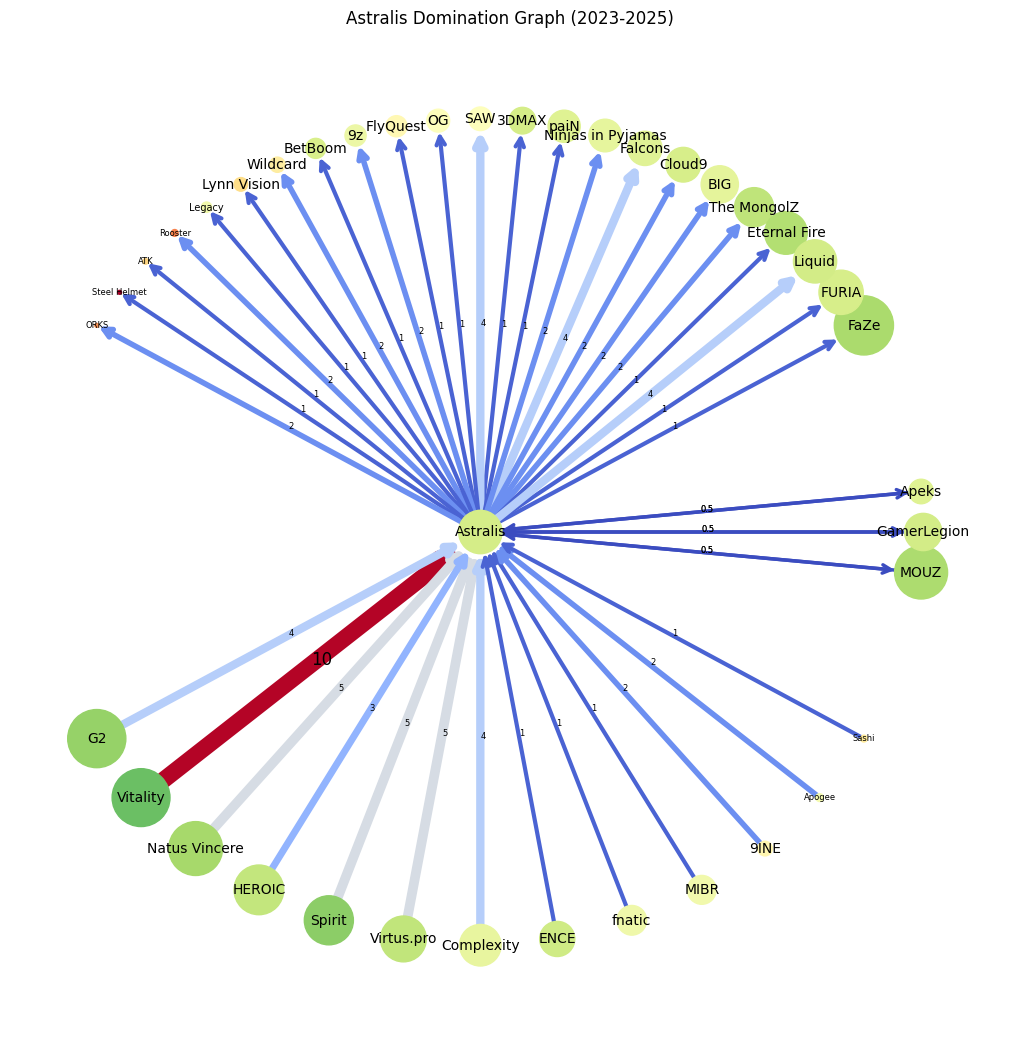

In [95]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import re
from collections import defaultdict
from datetime import datetime
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import PowerNorm
# Load the data
df = pd.read_csv("data/every_map.csv")

# Helper: extract clean team name (no parentheses)
def clean_name(name_with_score):
    return re.sub(r'\s*\(.*?\)', '', name_with_score)#.lower().strip()

# Clean names
df["Team1_Clean"] = df["Team1_Text"].apply(clean_name)
df["Team2_Clean"] = df["Team2_Text"].apply(clean_name)

# Convert date to datetime
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
astralis = "Astralis"
# Function to build domination graph for Astralis for a given time range
def build_domination_graph(df, start_year, end_year):
    global astralis
    # Filter for the date range
    df_range = df[(df["Date"].dt.year >= start_year) & (df["Date"].dt.year <= end_year)]
    
    # Create a dictionary to store total wins for each team (including Astralis)
    total_wins = defaultdict(int)
    total_losses = defaultdict(int)
    # Count wins for all teams in the time period
    for _, row in df_range.iterrows():
        t1, t2 = row["Team1_Clean"], row["Team2_Clean"]
        s1, s2 = row["Team1_Score"], row["Team2_Score"]
        
        if s1 > s2:
            total_wins[t1] += 1
            total_losses[t2] += 1
        elif s2 > s1:
            total_wins[t2] += 1
            total_losses[t1] += 1
    
    # Only games involving Astralis
    df_astralis = df_range[
        (df_range["Team1_Clean"] == astralis) | (df_range["Team2_Clean"] == astralis)
    ]

    matchups = defaultdict(lambda: {"maps": [0, 0], "rounds": [0, 0]})  # team -> [maps_won, rounds_won]

    for _, row in df_astralis.iterrows():
        t1, t2 = row["Team1_Clean"], row["Team2_Clean"]
        s1, s2 = row["Team1_Score"], row["Team2_Score"]

        # Identify opponent and who won
        if t1 == astralis:
            opponent = t2
            if s1 > s2:
                matchups[opponent]["maps"][0] += 1  # Astralis win
            elif s1 < s2:
                matchups[opponent]["maps"][1] += 1
            matchups[opponent]["rounds"][0] += s1
            matchups[opponent]["rounds"][1] += s2
        elif t2 == astralis:
            opponent = t1
            if s2 > s1:
                matchups[opponent]["maps"][0] += 1  # Astralis win
            elif s2 < s1:
                matchups[opponent]["maps"][1] += 1
            matchups[opponent]["rounds"][0] += s2
            matchups[opponent]["rounds"][1] += s1

    # Build graph
    G = nx.DiGraph()

    for opponent, stats in matchups.items():
        astralis_maps, opp_maps = stats["maps"]
        astralis_rounds, opp_rounds = stats["rounds"]

        # Add nodes with size attribute based on total wins
        G.add_node(astralis, size=total_wins.get(astralis, 1))
        G.add_node(opponent, size=total_wins.get(opponent, 1))

        if astralis_maps > opp_maps:
            G.add_edge(astralis, opponent, weight=astralis_maps - opp_maps)
        elif opp_maps > astralis_maps:
            G.add_edge(opponent, astralis, weight=opp_maps - astralis_maps)
        else:
            G.add_edge(astralis, opponent, weight=0.5)
            G.add_edge(opponent, astralis, weight=0.5)
            # tie in maps, go by rounds
            # if astralis_rounds > opp_rounds:
            #     G.add_edge("FURIA", opponent, weight=0.5)
            # elif opp_rounds > astralis_rounds:
            #     G.add_edge(opponent, "Astralis", weight=0.5)
            # If even rounds too, no edge
            
    cmap = cm.get_cmap('RdYlGn')  # reversed: red = low, green = high
    norm = PowerNorm(gamma=0.7, vmin=0, vmax=1)        
    node_colors = [cmap(norm(total_wins.get(node,0)/(total_losses[node]+total_wins[node]))) for node in G.nodes()]
    return G, node_colors

# Build both graphs


def custom_astralis_layout(G):
    center = astralis
    pos = {center: np.array([0.0, 0.0])}

    dominated = []
    dominated_by = []
    tied = []

    for node in G.nodes():
        if node == center:
            continue
        
        astralis_edge = G.get_edge_data(center, node)
        reverse_edge = G.get_edge_data(node, center)
        
        if astralis_edge and not reverse_edge:
            dominated.append(node)
        elif reverse_edge and not astralis_edge:
            dominated_by.append(node)
        elif astralis_edge and reverse_edge:
            tied.append(node)

    # Sort by node size (larger to smaller)
    dominated.sort(key=lambda n: G.nodes[n]['size'], reverse=True)
    dominated_by.sort(key=lambda n: G.nodes[n]['size'], reverse=True)
    tied.sort(key=lambda n: G.nodes[n]['size'], reverse=True)

    radius = 3

    def place_nodes(nodes, start_angle, end_angle):
        n = len(nodes)
        if n == 0:
            return
        angles = np.linspace(start_angle, end_angle, n)
        label_offsets = {}

        for angle, node in zip(angles, nodes):
            x = radius * np.cos(angle)
            y = radius * np.sin(angle)
            pos[node] = np.array([x, y])

    # Place dominated teams on the RIGHT (−π/2 to π/2)
    place_nodes(dominated, np.pi/6, 5*np.pi/6)

    # Place dominating teams on the LEFT (2π/3 to 4π/3)
    place_nodes(dominated_by, np.pi+(np.pi/6), np.pi+(5*np.pi/6))

    # Place tied teams on the BOTTOM (5π/4 to 7π/4)
    place_nodes(tied, -np.pi/32,np.pi/32)

    return pos

def draw_graph(G, nodecolors, title):
    pos = custom_astralis_layout(G)
    weights = [G[u][v]["weight"] for u, v in G.edges()]
    node_sizes = [G.nodes[node]['size'] * 8 for node in G.nodes()]
    
    # Normalize font sizes for nodes
    font_sizes = {node: min(10, max(6, G.nodes[node]['size'] * 1)) for node in G.nodes()}
    
    # Normalize font sizes for edges
    edge_font_sizes = { (u, v): min(14, max(6, G[u][v]['weight'] * 1.2)) for u, v in G.edges() }

    plt.figure(figsize=(10, 10))

    # Draw nodes and edges
    nx.draw(G, pos, node_color=nodecolors, edge_color=weights,
            edge_cmap=plt.cm.coolwarm, width=[2 + w for w in weights],
            node_size=node_sizes, arrows=True, arrowstyle='->', arrowsize=15)

    # Draw node labels with individual font sizes
    print(pos)
    for node, (x, y) in pos.items():
        # if y>-2.99:
        # Calculate angle from center
            angle = np.arctan2(y, x)
            dx = 0.15 * np.cos(angle)
            dy = 0.15 * np.sin(angle)
            dx, dy = 0,0
            plt.text(x + dx, y + dy, s=str(node), fontsize=font_sizes[node], ha='center', va='center')
        # else:
        #     if str(node)=="Astralis":
        #         plt.text(x + dx, -3.2, s=str(node), fontsize=font_sizes[node], ha='center', va='center')
        #     else:
        #         plt.text(x + dx, -2.9, s=str(node), fontsize=font_sizes[node], ha='center', va='center')

    # Draw edge labels with individual font sizes
    edge_labels = {(u, v): G[u][v]['weight'] for u, v in G.edges()}
    for (u, v), label in edge_labels.items():
        (x1, y1) = pos[u]
        (x2, y2) = pos[v]
        x, y = (x1 + x2) / 2, (y1 + y2) / 2
        plt.text(x, y, s=str(label), fontsize=edge_font_sizes[(u, v)], color='black')

    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Draw both
# start_old, end_old = 2012, 2014
start_new, end_new = 2023, 2025
# graph_2018_2019, nc_old = build_domination_graph(df, start_old, end_old)
graph_2023_2025, nc_new = build_domination_graph(df, start_new, end_new)
# draw_graph(graph_2018_2019, nc_old, f"{astralis} Domination Graph ({start_old}-{end_old})")
draw_graph(graph_2023_2025, nc_new, f"{astralis} Domination Graph ({start_new}-{end_new})")